<a href="https://colab.research.google.com/github/arifinnasif/Natural-Hazard-Prediction/blob/master/lightnet_on_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.nn as nn
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=True)
os.chdir(os.path.join("/content", "drive", "MyDrive", "Datasets", "GLM"))

Mounted at /content/drive


## ConvLSTM

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        # print("size of h_cur", h_cur.size())
        # print("size of combined", combined.size())

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
# conv_lstm = ConvLSTM(1,[8],[(5,5)],1, batch_first=True) # 1 channel, 8 hidden channel (from geng), 5x5 kernel, 1 layer(?), batch first -> batch er size input tensor e first e dicci,
# x = torch.rand((32, 6, 1, 25, 25)) # 32 samples in a batch (batch first), prev 6 hours, 1 channel, 25x25 grid
# # convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
# _, last_states = conv_lstm(x)
# h,c = last_states[0]  # 0 for layer index, 0 for h index
# print(last_states[0][1].size())
# print("-----")
# print(h.size())


In [ ]:
# x_ = torch.rand((32, 6, 50, 50))
# conv_ = nn.Conv2d(in_channels = 6, out_channels = 6*4, kernel_size = 5, groups = 6, stride = 2, padding = 2)
# # conv_.weight.data = [None, None, ...].repeat(64, 1, 1, 1)
# # print(conv_.weight.data.size())
# conv_(x_).size()

In [ ]:
class Encoder_old(nn.Module):
  def __init__(self):
    super(Encoder_old, self).__init__()
    self.prev_hours = 6
    self.conv_2 = nn.Conv2d(in_channels = self.prev_hours,
                          out_channels = self.prev_hours*4, # each input frame gets mapped to 4 layer
                          groups = self.prev_hours,
                          kernel_size = 7,
                          stride = 2,
                          padding = 3)
    self.conv_lstm = ConvLSTM(input_dim = 4,
                               hidden_dim = [8],
                               kernel_size = [(5,5)],
                               num_layers = 1,
                               batch_first=True)
    # print(self.conv_2.weight.data.size())

  def forward(self, input_tensor):
    x = self.conv_2(input_tensor.flatten(1,2))
    _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    h,c = last_states[0]

    return h,c





In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels_for_a_given_time, prev_hours):
    super(Encoder, self).__init__()
    self.prev_hours = prev_hours
    self.hidden_dim = 8
    self.stride = 2
    self.in_channels_for_a_given_time = in_channels_for_a_given_time
    self.conv_2 = nn.Conv2d(in_channels = self.in_channels_for_a_given_time, # one 2d lightnig grid at time t
                          out_channels = 4, # from geng
                          kernel_size = 7,
                          stride = self.stride,
                          padding = 3)
    self.conv_lstm_cell = ConvLSTMCell(input_dim = 4,
                               hidden_dim = self.hidden_dim,
                               kernel_size = (5,5),
                               bias=True)
    # print(self.conv_2.weight.data.size())

  def forward(self, input_tensor):
    # x = self.conv_2(input_tensor.flatten(1,2))
    # _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    # h,c = last_states[0]
    b, prev_hours, channels, height, width = input_tensor.size()
    h,c = self.init_hidden(batch_size=b, image_size=(height // self.stride, width // self.stride))

    for t in range(prev_hours):
      x = self.conv_2(input_tensor[:, t, :, :, :])
      h, c = self.conv_lstm_cell(x, cur_state=[h, c])
      return h,c

    #####

    #     layer_output_list = []
    #     last_state_list = []

    #     seq_len = input_tensor.size(1)
    #     cur_layer_input = input_tensor

    #     for layer_idx in range(self.num_layers):

    #         h, c = hidden_state[layer_idx]
    #         output_inner = []
    #         for t in range(seq_len):
    #             h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
    #                                              cur_state=[h, c])
    #             output_inner.append(h)

    #         layer_output = torch.stack(output_inner, dim=1)
    #         cur_layer_input = layer_output

    #         layer_output_list.append(layer_output)
    #         last_state_list.append([h, c])

    #     if not self.return_all_layers:
    #         layer_output_list = layer_output_list[-1:]
    #         last_state_list = last_state_list[-1:]

    #     return layer_output_list, last_state_list

    # return h,c

  def init_hidden(self, batch_size, image_size):
      height, width = image_size
      return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_2.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_2.weight.device))





In [ ]:
class Fusion(nn.Module):
  def __init__(self, total_in_channels):
    super(Fusion,self).__init__()
    # h_stacked = torch.cat(h_list, dim = 1)
    # sc_stacked = torch.cat(c_list, dim = 1)
    self.conv_3 = nn.Conv2d(in_channels = total_in_channels,
                            out_channels = 64, # from the paper
                            kernel_size=1)
    self.conv_4 = nn.Conv2d(in_channels = total_in_channels,
                            out_channels = 64, # from the paper
                            kernel_size=1)

  def forward(self, h_list, c_list):
    h_stacked = torch.cat(h_list, dim = 1)
    c_stacked = torch.cat(c_list, dim = 1)


    h_fused_conved = self.conv_3(h_stacked)
    c_fused_conved = self.conv_4(c_stacked)

    return h_fused_conved, c_fused_conved


In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels_for_a_given_time, next_hours):
    super(Decoder, self).__init__()
    self.next_hours = next_hours
    self.in_channels_for_a_given_time = in_channels_for_a_given_time
    self.conv_5 = nn.Conv2d(in_channels = self.in_channels_for_a_given_time, # single L_{-1} frame
                          out_channels = 4, # from geng
                          kernel_size = 7,
                          stride = 2,
                          padding = 3)
    self.conv_lstm_cell = ConvLSTMCell(input_dim=4, # output of conv
                                       hidden_dim=64, # from geng
                                       kernel_size=(5,5), # from geng
                                       bias=True)
    # print(self.conv_2.weight.data.size())
    self.deconv = nn.ConvTranspose2d(in_channels=64, # as previous conv_lstm_cell had 64 hidden dim so the size is [:,64,:,:]
                                     out_channels=64, # from geng
                                     kernel_size = 7, # from geng
                                     stride = 2, # from geng
                                     padding = 3,
                                     output_padding = 1) # not sure

    self.conv_6 = nn.Conv2d(in_channels = 64, # previous deconv
                          out_channels = 1, # as it is just one layer
                          kernel_size = 1, # from geng
                          stride = 1) # from geng

  def forward(self, input_tensor_L_neg_1, h, c):
    # x = self.conv_2(input_tensor.flatten(1,2))
    # _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    # h,c = last_states[0]
    b, _, height, width = input_tensor_L_neg_1.size()

    pred_output = []

    for i in range(self.next_hours):
      # print("---")
      x = self.conv_5(input_tensor_L_neg_1)
      # print(x.size())
      # print("dbg", x.size())
      h, c = self.conv_lstm_cell(x, cur_state=[h, c])
      # print(h.size())
      x = self.deconv(h)
      # print(x.size())
      x = self.conv_6(x)
      # print(x.size())

      pred_output.append(x)
      # print("---")

    pred_output = torch.stack(pred_output, 0).permute(1, 0, 2, 3, 4)
    # print(torch.stack(pred_output, 0).size())





    return pred_output



In [ ]:
class LightNet(nn.Module):
  def __init__(self):
    super(LightNet, self).__init__()
    self.obs_enc = Encoder(in_channels_for_a_given_time=1,
                           prev_hours=6)
    self.fus = Fusion(8) # total h (or c) channels. as we are going to use just one h from the obs encoder (size of h = [:,8,:,:])
    self.pred_dec = Decoder(in_channels_for_a_given_time=1,
                            next_hours=6)

  def forward(self, input_tensor):
    h,c = self.obs_enc(input_tensor)
    h,c = self.fus([h],[c])
    out = self.pred_dec(input_tensor[:,-1,:,:,:], h, c)

    return out

In [ ]:
# model = LightNet()
# x = torch.rand((32, 6, 1, 50, 50)) # [batch_size, prev_hours, input_layer, image_height, image_width]
# model(x)

In [ ]:
def MeteorologicalMeasures(output, target):
  output, target = output.to(torch.device("cuda")), target.to(torch.device("cuda"))
  true_pos = 0
  true_neg = 0

  false_pos = 0
  false_neg = 0

  ytrue = target
  ypred = torch.sigmoid(output)
  ypred = torch.round(ypred)
  true_positives = torch.sum(ytrue * ypred)
  false_positives = torch.sum((1-ytrue)*ypred)
  possible_positives = torch.sum(ytrue)
  POD = true_positives / (possible_positives + 1e-10)
  predicted_positives = torch.sum(ypred)
  FAR = false_positives / (predicted_positives + 1e-10)
  return POD, FAR



In [ ]:
def weighted_cross_entropy_with_logits(logits, targets, pos_weight):
    return torch.sum(targets * -torch.sigmoid(logits).log() * pos_weight + (1 - targets) * -(1 - torch.sigmoid(logits)).log())/logits.size(0)

data has the size :  torch.Size([1000, 1, 50, 50])
Epoch [ 1 / 50 ] 

100%|██████████| 26/26 [01:22<00:00,  3.16s/it]


train
loss 10636.254574919585 | acc 0.6746104967948718 | POD 0.22635046399457304 | FAR 0.6103503040764343
validation
loss 8304.258338507487 | acc 0.020246354166666668 | POD 0.0 | FAR 0.0

Epoch [ 2 / 50 ] 

100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


train
loss 7909.51006219795 | acc 0.014849759615384615 | POD 0.0 | FAR 0.0
validation
loss 7593.925623785663 | acc 0.0061234375 | POD 0.0 | FAR 0.0

Epoch [ 3 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 7614.916819514776 | acc 0.0056354967948717945 | POD 0.0 | FAR 0.0
validation
loss 7429.409919428696 | acc 0.004748958333333333 | POD 0.0 | FAR 0.0

Epoch [ 4 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 7429.164902259702 | acc 0.0047207532051282055 | POD 0.0 | FAR 0.0
validation
loss 7215.161432858989 | acc 0.0056010416666666665 | POD 0.0 | FAR 0.0

Epoch [ 5 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 7063.950012084498 | acc 0.008137419871794872 | POD 0.0009826020915899463 | FAR 0.31657489034181574
validation
loss 6631.688427872971 | acc 0.0189578125 | POD 0.010100515650933336 | FAR 0.8759906364312519

Epoch [ 6 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 6036.2385875484815 | acc 0.029355448717948717 | POD 0.13057893711211302 | FAR 0.8804531034941069
validation
loss 5466.934313102678 | acc 0.049115104166666666 | POD 0.31368080225767053 | FAR 0.9161957489906108

Epoch [ 7 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 5241.941626804411 | acc 0.04909102564102564 | POD 0.36299325624420514 | FAR 0.9033083245423754
validation
loss 4996.330625645688 | acc 0.0496203125 | POD 0.3615467059460534 | FAR 0.8946121574639834

Epoch [ 8 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4819.239510448522 | acc 0.05136426282051282 | POD 0.4238619621049195 | FAR 0.8872191923907019
validation
loss 4660.506218583307 | acc 0.05401458333333333 | POD 0.458289309457662 | FAR 0.891261555387162

Epoch [ 9 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4534.309340160156 | acc 0.0535818108974359 | POD 0.5058527045382737 | FAR 0.8842379150156525
validation
loss 4437.206961823562 | acc 0.055275520833333334 | POD 0.5154043299120337 | FAR 0.8871296802687831

Epoch [ 10 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4346.846949818002 | acc 0.05295969551282051 | POD 0.5505224482099138 | FAR 0.8797809964200144
validation
loss 4281.5839539547 | acc 0.0541390625 | POD 0.5487978757346452 | FAR 0.8833460176891443

Epoch [ 11 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4213.245320464806 | acc 0.05150280448717949 | POD 0.5782785973382469 | FAR 0.8761102284738433
validation
loss 4162.302051852379 | acc 0.052603125 | POD 0.5728893147132296 | FAR 0.8792890149381045

Epoch [ 12 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4108.570072128243 | acc 0.050231490384615385 | POD 0.5985158685987956 | FAR 0.872560239279108
validation
loss 4062.1177818147567 | acc 0.05090104166666667 | POD 0.5901062350839124 | FAR 0.8752594209338815

Epoch [ 13 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 4021.837675922936 | acc 0.04900528846153846 | POD 0.6141736964970901 | FAR 0.8693115629863546
validation
loss 3978.949943134856 | acc 0.04891510416666667 | POD 0.602298663615947 | FAR 0.8709821448187418

Epoch [ 14 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3947.0835546778276 | acc 0.04752676282051282 | POD 0.6261766454367671 | FAR 0.8661406820963448
validation
loss 3907.6400678037508 | acc 0.046944791666666666 | POD 0.6118948521144913 | FAR 0.8669908144027815

Epoch [ 15 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3878.8247875756497 | acc 0.04601298076923077 | POD 0.6350791997879024 | FAR 0.8628290407654844
validation
loss 3842.0459697979245 | acc 0.0450703125 | POD 0.6177957745791477 | FAR 0.863027649771717

Epoch [ 16 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3813.1150187623175 | acc 0.044594471153846155 | POD 0.6420412475413225 | FAR 0.8593333574600837
validation
loss 3780.8086060187175 | acc 0.042896875 | POD 0.6211905817553481 | FAR 0.8565176864781088

Epoch [ 17 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3750.2483688207453 | acc 0.04319070512820513 | POD 0.6478509026319983 | FAR 0.8553569863970937
validation
loss 3724.1177153151975 | acc 0.0413203125 | POD 0.6229531013606956 | FAR 0.8511748173289593

Epoch [ 18 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3693.9566326867953 | acc 0.0419025641025641 | POD 0.6527164823361351 | FAR 0.8516603692221607
validation
loss 3673.0279290257 | acc 0.04032135416666666 | POD 0.6337517682368122 | FAR 0.8485539866948889

Epoch [ 19 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3644.4224633143463 | acc 0.04072379807692308 | POD 0.6574009085260448 | FAR 0.8481853295597569
validation
loss 3626.3970137570846 | acc 0.0397234375 | POD 0.6419066492688434 | FAR 0.8467316041151771

Epoch [ 20 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3598.385280982922 | acc 0.03974206730769231 | POD 0.6618951453708669 | FAR 0.8448781395969824
validation
loss 3583.394635804766 | acc 0.038946875 | POD 0.6472034179424806 | FAR 0.8437106672239705

Epoch [ 21 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3555.628852752393 | acc 0.038921073717948715 | POD 0.6668448512455036 | FAR 0.8417040692999224
validation
loss 3542.4545948155405 | acc 0.038319791666666665 | POD 0.6534402442565597 | FAR 0.8411324384666945

Epoch [ 22 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3514.5049747817216 | acc 0.03817283653846154 | POD 0.6713655673364463 | FAR 0.8387238461859702
validation
loss 3502.442831106714 | acc 0.037659375 | POD 0.6570322222987178 | FAR 0.8385477184769801

Epoch [ 23 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3473.87309723413 | acc 0.03750817307692308 | POD 0.6756555486058804 | FAR 0.8356926295746452
validation
loss 3462.2292289591205 | acc 0.0369828125 | POD 0.6618513507725616 | FAR 0.8356482550929774

Epoch [ 24 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3433.3201354466432 | acc 0.0368463141025641 | POD 0.6806414626930534 | FAR 0.8324479207933091
validation
loss 3421.840478248897 | acc 0.036303645833333335 | POD 0.6662456402519997 | FAR 0.8329430900583071

Epoch [ 25 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3394.1209243760313 | acc 0.03608261217948718 | POD 0.6847079474846074 | FAR 0.8292216281446987
validation
loss 3384.1257313768656 | acc 0.03571041666666667 | POD 0.6722535112813133 | FAR 0.8302782752483463

Epoch [ 26 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3359.829478936954 | acc 0.03535088141025641 | POD 0.6889024859843809 | FAR 0.8261565157704727
validation
loss 3352.6343287446043 | acc 0.035315104166666667 | POD 0.6784238971616732 | FAR 0.8287195512573672

Epoch [ 27 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3331.7369306329324 | acc 0.03474286858974359 | POD 0.6926985121038499 | FAR 0.8238297433378539
validation
loss 3328.441642498645 | acc 0.03550260416666667 | POD 0.6861971891570311 | FAR 0.8290278916165927

Epoch [ 28 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3307.5201951853187 | acc 0.034284375 | POD 0.6962206678507425 | FAR 0.8219063328534278
validation
loss 3312.5500319456196 | acc 0.0360515625 | POD 0.6953230386408731 | FAR 0.8306814658248372

Epoch [ 29 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3284.474950334042 | acc 0.033965625 | POD 0.6994535202322184 | FAR 0.8204672407438243
validation
loss 3293.524662044223 | acc 0.03591822916666667 | POD 0.7003835075761609 | FAR 0.8304155819552865

Epoch [ 30 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3262.1915518794367 | acc 0.033719391025641025 | POD 0.703072128947047 | FAR 0.8192559731854351
validation
loss 3271.1304847757438 | acc 0.03529270833333333 | POD 0.7026826368613239 | FAR 0.8284652425077771

Epoch [ 31 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3242.7250136676785 | acc 0.033447435897435894 | POD 0.7054427799157221 | FAR 0.8181257756972956
validation
loss 3253.625561503565 | acc 0.034955729166666664 | POD 0.7046986339977079 | FAR 0.8273638850232823

Epoch [ 32 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3225.8799175076665 | acc 0.03317291666666667 | POD 0.7076885114201291 | FAR 0.8169953313709957
validation
loss 3238.557660890078 | acc 0.03472135416666667 | POD 0.7076583701289714 | FAR 0.8266089125686261

Epoch [ 33 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3210.3757100740845 | acc 0.032905929487179485 | POD 0.7098153623319393 | FAR 0.8159276894078134
validation
loss 3224.3219741605208 | acc 0.034491145833333334 | POD 0.7100928398925221 | FAR 0.825678358969332

Epoch [ 34 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3195.8322903098906 | acc 0.03265400641025641 | POD 0.7122249506898661 | FAR 0.8148488689600448
validation
loss 3210.880982311159 | acc 0.03422760416666667 | POD 0.7127664118533792 | FAR 0.8248311024269996

Epoch [ 35 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3182.23674144865 | acc 0.032394951923076926 | POD 0.7139491783377442 | FAR 0.8139726596485582
validation
loss 3198.386408088458 | acc 0.033972395833333335 | POD 0.7140631583127066 | FAR 0.8241989546341791

Epoch [ 36 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3169.5126167961944 | acc 0.0321568108974359 | POD 0.715567257607442 | FAR 0.8130338964152658
validation
loss 3186.754388406302 | acc 0.03376822916666666 | POD 0.7147792780663961 | FAR 0.8236587522639817

Epoch [ 37 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3157.5305032765946 | acc 0.031931169871794875 | POD 0.7172859051316685 | FAR 0.8121107176527531
validation
loss 3175.838972866362 | acc 0.03360520833333333 | POD 0.7169327943694912 | FAR 0.8227348316225839

Epoch [ 38 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3146.187798051418 | acc 0.03167596153846154 | POD 0.7185304480128365 | FAR 0.8112358798251837
validation
loss 3165.5464914913823 | acc 0.033374479166666665 | POD 0.7184590549787632 | FAR 0.8220461914281785

Epoch [ 39 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3135.415392844058 | acc 0.03147011217948718 | POD 0.7197972365668659 | FAR 0.8103513962337446
validation
loss 3155.8129118835077 | acc 0.03323333333333333 | POD 0.7188376027216014 | FAR 0.8215531387932057

Epoch [ 40 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3125.1550080848415 | acc 0.03128149038461538 | POD 0.7206353190104404 | FAR 0.8096369970425635
validation
loss 3146.5698557723463 | acc 0.033055208333333336 | POD 0.7191337612348846 | FAR 0.8210323758365761

Epoch [ 41 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3115.348783931637 | acc 0.031091266025641027 | POD 0.7213135080384402 | FAR 0.8089109205206413
validation
loss 3137.7439621589274 | acc 0.0329203125 | POD 0.7208082653330032 | FAR 0.8203814388551003

Epoch [ 42 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3105.9418025011864 | acc 0.030907772435897436 | POD 0.7222851706440019 | FAR 0.808119908398025
validation
loss 3129.2702860785184 | acc 0.03280104166666667 | POD 0.7219989210525188 | FAR 0.8197849595189534

Epoch [ 43 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3096.8855966694787 | acc 0.03075448717948718 | POD 0.7231926509150928 | FAR 0.8073604136856234
validation
loss 3121.0994912294755 | acc 0.032663020833333334 | POD 0.7239093826608274 | FAR 0.8190704956170874

Epoch [ 44 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3088.138247186943 | acc 0.030604967948717948 | POD 0.7238861287539936 | FAR 0.806660384453419
validation
loss 3113.1963888993973 | acc 0.03253333333333333 | POD 0.724140286522272 | FAR 0.8186346726786008

Epoch [ 45 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3079.6629793858056 | acc 0.030443189102564102 | POD 0.7244950570070964 | FAR 0.8060079875846038
validation
loss 3105.5346771223913 | acc 0.032403125 | POD 0.7244154285381 | FAR 0.8181350417004537

Epoch [ 46 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3071.426888820813 | acc 0.030308173076923076 | POD 0.7251262094175502 | FAR 0.805333107269311
validation
loss 3098.0919246246026 | acc 0.03232395833333333 | POD 0.7251238281746581 | FAR 0.8176171344833936

Epoch [ 47 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3063.4002521455695 | acc 0.030183333333333333 | POD 0.725793455709261 | FAR 0.8047439431316158
validation
loss 3090.8469074514037 | acc 0.032210416666666665 | POD 0.7259862743105812 | FAR 0.8171907273837653

Epoch [ 48 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3055.5566194705793 | acc 0.030054326923076923 | POD 0.7262618701810654 | FAR 0.8041201095246403
validation
loss 3083.7804026825133 | acc 0.032115104166666665 | POD 0.7270860943575941 | FAR 0.816699340448512

Epoch [ 49 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3047.873683846752 | acc 0.029934775641025643 | POD 0.7268040002690649 | FAR 0.8035549993945911
validation
loss 3076.879156920182 | acc 0.032046875 | POD 0.7282314655666088 | FAR 0.81606918224681

Epoch [ 50 / 50 ] 

100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


train
loss 3040.333869267924 | acc 0.029821233974358975 | POD 0.7275927201761216 | FAR 0.8029444258549507
validation
loss 3070.1375681370146 | acc 0.03200104166666667 | POD 0.7290830828598917 | FAR 0.8155679868059399

50 50


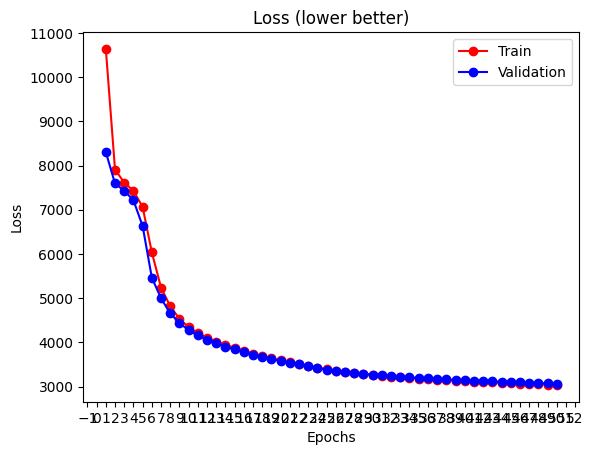

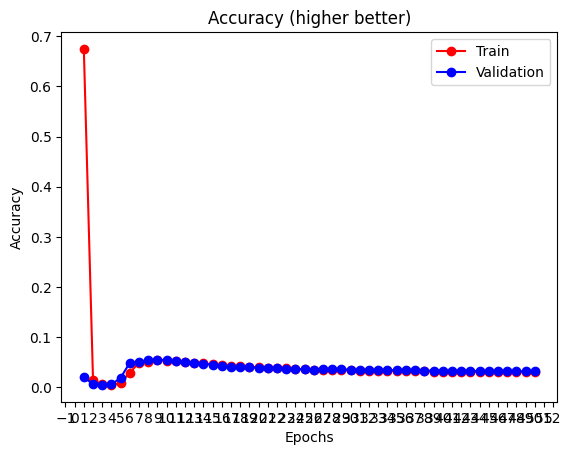

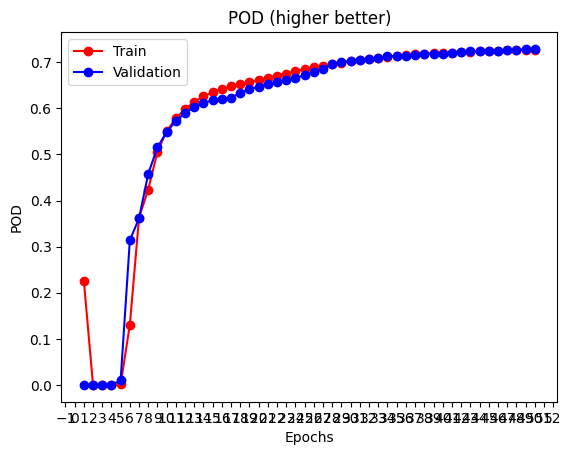

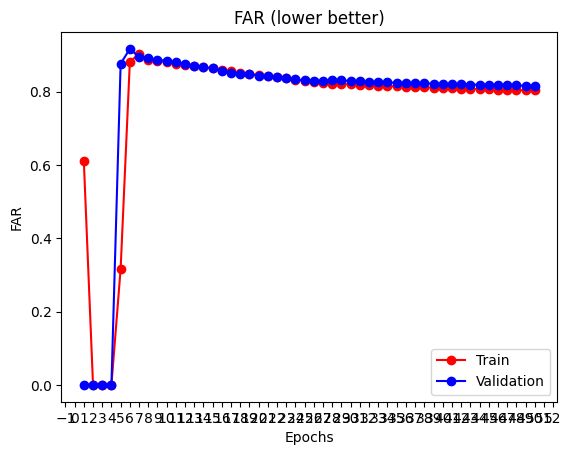

In [ ]:
def train(model):
  # random data
  # data = torch.rand((1024,1,50,50), dtype=torch.double)
  # data[data>0.5] = 1.0
  # data[data<0.5] = 0.0

  # GLM data

  data = torch.from_numpy(np.load('flash_count_array.npy')).double()
  data[data>1.0] = 1.0
  print("data has the size : ", data.size())

  train_pct = 0.85
  prev_hours = 6
  next_hours = 6
  batch_size = 32
  start_index_list = list(range(data.size(0) - prev_hours - next_hours))
  random.shuffle(start_index_list)
  train_start_index_list = start_index_list[:int(len(start_index_list)*train_pct)]
  val_start_index_list = start_index_list[int(len(start_index_list)*train_pct):]
  # print("hello")

  # print(len(train_start_index_list))
  # print(len(val_start_index_list))

  ## train set creation
  train_x_set = []
  train_y_set = []
  for i in range(len(train_start_index_list) // batch_size):
    train_x_batch = []
    train_y_batch = []
    for j in range(batch_size):
      start = train_start_index_list[batch_size * i + j]
      train_x_batch.append(data[start:(start+prev_hours),:,:,:])
      train_y_batch.append(data[(start+prev_hours):(start+prev_hours+next_hours),:,:,:])

    train_x_batch = torch.stack(train_x_batch,0)
    train_y_batch = torch.stack(train_y_batch,0)

    train_x_set.append(train_x_batch)
    train_y_set.append(train_y_batch)

  # train_x_set = torch.stack(train_x_set,0)
  # train_y_set = torch.stack(train_y_set,0)
  # print(train_x_set.size())
  # print(train_y_set.size())

  ## validation set creation
  val_x_set = []
  val_y_set = []
  for i in range(len(val_start_index_list) // batch_size):
    val_x_batch = []
    val_y_batch = []
    for j in range(batch_size):
      start = val_start_index_list[batch_size * i + j]
      val_x_batch.append(data[start:(start+prev_hours),:,:,:])
      val_y_batch.append(data[(start+prev_hours):(start+prev_hours+next_hours),:,:,:])

    val_x_batch = torch.stack(val_x_batch,0)
    val_y_batch = torch.stack(val_y_batch,0)

    val_x_set.append(val_x_batch)
    val_y_set.append(val_y_batch)

  # val_x_set = torch.stack(val_x_set,0)
  # val_y_set = torch.stack(val_y_set,0)
  # print(val_x_set.size())
  # print(val_y_set.size())
  # print(data[start:(start+prev_hours+next_hours),:,:,:].size())

  model.double()
  # print(model(train_x_set[0]).size())

  ce_loss = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  epoch = 50

  avg_train_loss_list = []
  avg_val_loss_list = []
  avg_train_POD_list = []
  avg_train_FAR_list = []
  avg_train_ETS_list = []
  train_accuracy_list = []
  avg_val_POD_list = []
  avg_val_FAR_list= []
  avg_val_ETS_list = []
  val_accuracy_list = []

  for e in range(epoch):
    avg_train_loss = 0
    avg_val_loss = 0
    avg_train_POD = 0
    avg_train_FAR = 0
    avg_train_ETS = 0
    train_correct = 0
    avg_val_POD = 0
    avg_val_FAR = 0
    avg_val_ETS = 0
    val_correct = 0

    print("Epoch [",e+1,"/",epoch,"]", end=" ")

    for i in tqdm(range(len(train_x_set))):
      data, target = train_x_set[i].to(torch.device("cuda")), train_y_set[i].to(torch.device("cuda"))
      optimizer.zero_grad()
      # train
      model.train()
      output = model(data)
      # train_loss = ce_loss(output, target)
      train_loss = weighted_cross_entropy_with_logits(output, target, 16)
      train_POD, train_FAR = MeteorologicalMeasures(output, target)
      avg_train_loss = avg_train_loss + train_loss.item()
      avg_train_POD = avg_train_POD + train_POD.item()
      avg_train_FAR = avg_train_FAR + train_FAR.item()
      train_correct += (output.round() == target).double().sum()
      # avg_train_ETS = avg_train_ETS + train_ETS
      train_loss.backward()
      optimizer.step()


    for i in range(len(val_x_set)):
      data, target = val_x_set[i].to(torch.device("cuda")), val_y_set[i].to(torch.device("cuda"))
      # val
      model.eval()
      output = model(data)
      # val_loss = ce_loss(output, target)
      val_loss = weighted_cross_entropy_with_logits(output, target, 16)
      val_POD, val_FAR = MeteorologicalMeasures(output, target)
      avg_val_loss = avg_val_loss + val_loss.item()
      avg_val_POD = avg_val_POD + val_POD.item()
      avg_val_FAR = avg_val_FAR + val_FAR.item()
      val_correct += (output.round() == target).double().sum()
      # avg_val_ETS = avg_val_ETS + val_ETS
      # train_loss.backward()
      # optimizer.step()
    avg_train_loss = avg_train_loss / len(train_x_set)
    avg_train_POD = avg_train_POD / len(train_x_set)
    avg_train_FAR = avg_train_FAR / len(train_x_set)
    avg_train_ETS = avg_train_ETS / len(train_x_set)
    train_accuracy = train_correct.item() / (len(train_x_set)*batch_size*next_hours*50*50)

    avg_train_loss_list.append(avg_train_loss)
    avg_train_POD_list.append(avg_train_POD)
    avg_train_FAR_list.append(avg_train_FAR)
    train_accuracy_list.append(train_accuracy)

    avg_val_loss = avg_val_loss / len(val_x_set)
    avg_val_POD = avg_val_POD / len(val_x_set)
    avg_val_FAR = avg_val_FAR / len(val_x_set)
    avg_val_ETS = avg_val_ETS / len(val_x_set)
    val_accuracy = val_correct.item() / (len(val_x_set)*batch_size*next_hours*50*50)

    avg_val_loss_list.append(avg_val_loss)
    avg_val_POD_list.append(avg_val_POD)
    avg_val_FAR_list.append(avg_val_FAR)
    val_accuracy_list.append(val_accuracy)

    print("train")
    print("loss", avg_train_loss,"|", "acc", train_accuracy,"|", "POD", avg_train_POD,"|", "FAR", avg_train_FAR)#,"|", "train ETS", avg_train_ETS)
    print("validation")
    print("loss", avg_val_loss,"|", "acc", val_accuracy,"|", "POD", avg_val_POD,"|", "FAR", avg_val_FAR)#,"|", "val ETS", avg_val_ETS)
    print()


  print(epoch, len(avg_train_loss_list))
  ## LOSS
  plt.title('Loss (lower better)')
  plt.plot(range(1, epoch+1), avg_train_loss_list, color='red', marker='o', label='Train')
  plt.plot(range(1, epoch+1), avg_val_loss_list, color='blue', marker='o', label='Validation')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  ## ACCURACY
  plt.title('Accuracy (higher better)')
  plt.plot(range(1, epoch+1), train_accuracy_list, color='red', marker='o', label='Train')
  plt.plot(range(1, epoch+1), val_accuracy_list, color='blue', marker='o', label='Validation')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  ## POD
  plt.title('POD (higher better)')
  plt.plot(range(1, epoch+1), avg_train_POD_list, color='red', marker='o', label='Train')
  plt.plot(range(1, epoch+1), avg_val_POD_list, color='blue', marker='o', label='Validation')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("POD")
  plt.show()

  ## FAR
  plt.title('FAR (lower better)')
  plt.plot(range(1, epoch+1), avg_train_FAR_list, color='red', marker='o', label='Train')
  plt.plot(range(1, epoch+1), avg_val_FAR_list, color='blue', marker='o', label='Validation')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("FAR")
  plt.show()
      # if batch_idx % args.log_interval == 0:
      # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #             epoch, i * len(data), len(train_loader.dataset),
      #             100. * batch_idx / len(train_loader), loss.item()))
      #         if args.dry_run:
      #             break
      # for i in range(opt.steps):
      #     print('STEP: ', i)
      #     def closure():
      #         optimizer.zero_grad()
      #         out = seq(input)
      #         loss = criterion(out, target)
      #         print('loss:', loss.item())
      #         loss.backward()
      #         return loss
      #     optimizer.step(closure)


model = LightNet()
model.to(torch.device('cuda'))
train(model)


In [ ]:
# x = torch.rand((32, 6, 1, 50, 50))
# enc = Encoder()
# h,c = enc(x)
# # print(h.size(1)+c.size(1))
# fus = Fusion(h.size(1))
# h,c = fus([h], [c])
# dec = Decoder()
# print("size of x[:,-1,:,:,:]", x[:,-1,:,:,:].size())
# print(h.size())
# out = dec(x[:,-1,:,:,:], h,c)
# print(h.size())
# print(c.size())
# print(torch.cat([h,c], dim=1).size())